# QAOA In The field of smart charging of electric vehicles --- Problem 1: Minimizing the total weighted charging time
Authors: Kevin Shen, Catharina Broocks, Jakob Pforr, Franziska Wilfinger, Jezer Jojo

In [1]:
from IPython.display import Image
from IPython.display import HTML
HTML(open('stylesheet.css').read())

Credits to Aline Lefebvre for the css style sheet template.

<div class = "Prob"> 
We're given $n$ vehicles that need to be charged. Some vehicles are more important than others (ambulances for example) and so each vehicle is assigned a 'weight' $w_i$ accordingly. Each vehicle also has a charging time $t_i$. Now, given $k$ charging ports, the question is this: Which charging port should each vehicle ideally be directed to and in what order?

So there are two sub-questions here. The arguably easier problem is "Given a group of vehicles in a queue waiting on a single charging port, what order should they be in?". Larger weights and shorter charging times should be given preference. So a fair solution is to arrange the vehicles in decreasing order of $\frac{w_i}{t_i}$.

The harder problem that comes before this one is "How would you distribute vehicles to different charging ports in the first place?"
To deal with this problem, we first construct a weighted complete graph where each node represents a vehicle. The weight of the edge connecting nodes $i$ and $j$ is $\min \{w_i t_j, w_j t_i\}$. This weight is the 'cost' incurred if the vehicles represented by these nodes were sent to the same charging port. $w_i t_j$ is the price $i$ pays if it has to wait for $j$, and $w_j t_i$ is the price $j$ pays if it has to wait for $i$. We know we can pick the minimum because we've already solved the problem of ordering in the previous question.

In terms of this graph then, the question becomes "How can we divide this graph into $k$ connected graphs such that the weights of the edges that remain are minimized?", or "How can we divide this graph into $k$ connected graphs such that the weights of the edges that we remove are maximized?". This is the Max-k-cut problem, and it can be solved using QAOA.

## Settings 

### Import packages

<div class='Plain'> The functions used in this notebook are stored in our python package "/Code". External packages to be imported include nextworkx for creating graph objects, scipy for optimization as well as the usual packages numpy and matplotlib. Quantum circuits are defined using the library Qiskit, which is imported in our python files in "/Code". 

In [1]:
from Code.data_processing import *
from Code.Max_k_cut_quantum_functions import *
from Code.Max_k_cut_classical_functions import *
import networkx as nx
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import numpy as np

### Define global parameters and settings

<div class='Plain'> We define here some global parameters and settings which include: <br>
    
n: The total number of nodes
    
n_imp: The number of important nodes, or to say the nodes with which the associated edges have larger weights
    
n_unimp: The number of less important nodes ... smaller weights
    
l: The number of qubits to encode each node
    
k: The number of partitions we are allowed to cut
    
p: The depth of the quantum circuit, ie. the number of layers
    
nshots: The number of shots per iteration
    
init_params: The initial parameters gammas and betas   <br>
This is however unused in the full optimization loop since the educated global guess optimization does not require initial guesses. The init_params here will be used later to demonstrate the performance of a local optimzation alone.

local_optimization_method: The local optimization algorithm to be used <br>
Good candidates include 
'Powell', 'COBYLA', 'Nelder-Mead', 'BFGS'

In [3]:
n_imp = 3 
n_unimp = 2
n = n_imp + n_unimp 
l = 2
k = 2**l 
p = 3
nshots = 512
init_params = [np.pi/8, np.pi]*p
local_optimization_method = 'Powell'

### Generate sample problem

<div class='Plain'> Let's generate a sample max-4-cut problem on which we will illustrate the implementation of the QAOA algorithm.

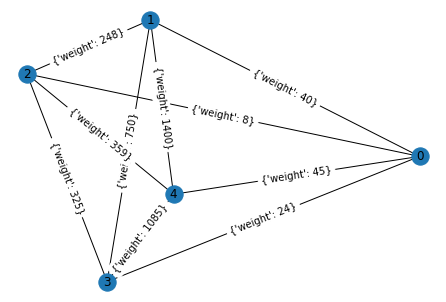

In [4]:
G = generate_data(n_unimp, n_imp)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)
nx.draw_networkx_edge_labels(G, pos)
plt.show()

<div class='Plain'> We can equivalently have a weight-matrix representation for this problem

<div class='Rmk'> As suggested in the paper, it is preferred to normalize the weight matrix which would help confine the parameters within a small range and simplify the function landscape.

In [5]:
weights = get_weight_matrix(G)            # Obtain the weight matrix
R = compute_normalization_scale(weights)  # The normalization scale suggested by the paper
rescaled_weights = weights / R            # The rescaled weight matrix

print('original weight matrix =', weights)
print('normalization factor =', R)
print('rescaled weight matrix =', rescaled_weights)

original weight matrix = [[   0   40    8   24   45]
 [  40    0  248  750 1400]
 [   8  248    0  325  359]
 [  24  750  325    0 1085]
 [  45 1400  359 1085    0]]
normalization factor = 8750.0
rescaled weight matrix = [[0.         0.00457143 0.00091429 0.00274286 0.00514286]
 [0.00457143 0.         0.02834286 0.08571429 0.16      ]
 [0.00091429 0.02834286 0.         0.03714286 0.04102857]
 [0.00274286 0.08571429 0.03714286 0.         0.124     ]
 [0.00514286 0.16       0.04102857 0.124      0.        ]]


### Optimal result by brute force

<div class='Plain'> Before implementing the QAOA algorithm, we first compute the optimal solution for our sample problem by brute force. This solution would then serve as the reference for us to evaluate our QAOA implementation.

In [6]:
cost_of_graph, partition = brut_force(G,k)  
normalized_cost = cost_of_graph / R

print('original cost =', cost_of_graph)
print('normalized cost =', normalized_cost)

C_opt= 4276   P_opt= {'P0': [0, 2], 'P1': [4], 'P2': [3], 'P3': [1]}
original cost = 4276
normalized cost = 0.4886857142857143


## QAOA Implementation break into parts

<div class='Plain'> We will now break our QAOA solution into parts and illustrate one by one.

### Encoding qubits
<div class = "Exp"> 
To simplify things we constrain our problem such that $k$ is a power of $2$. Let's say $k=2^l$.
We arrange our qubits into $n$ registers where $n$ is the number of vehicles. Each register has $l$ qubits. 

### Initializing qubits
<div class='Implementation'>
Before applying Cost Hamiltonians and Mixer Hamiltonians on the qubits, we wish to bring the qubits into the equal superposition state by applying a Hadamard gate on each qubit.

In [7]:
ib = make_initial_block(n,l)
ib.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     ├───┤
q_3: ┤ H ├
     ├───┤
q_4: ┤ H ├
     ├───┤
q_5: ┤ H ├
     ├───┤
q_6: ┤ H ├
     ├───┤
q_7: ┤ H ├
     ├───┤
q_8: ┤ H ├
     ├───┤
q_9: ┤ H ├
     └───┘

### Constructing the Mixer Hamiltonian

<div class = "Implementation">  <br>
For the mixer hamiltonian $H_M$, we pick $\sum\limits_{i=1}^{n}{X}$.
    
The unitary operation for $e^{-i H_M \beta}$ is then implemented by applying $R_X(2\beta)$ gates on every qubit.
The initial state for this mixer is one where every qubit is in the plus state so we start by applying $H$ gates on every qubit.

In [8]:
mb = make_mixing_block(n,l,1)
mb.draw()

┌──────────┐
q_0: ┤ RX(2*β1) ├
     ├──────────┤
q_1: ┤ RX(2*β1) ├
     ├──────────┤
q_2: ┤ RX(2*β1) ├
     ├──────────┤
q_3: ┤ RX(2*β1) ├
     ├──────────┤
q_4: ┤ RX(2*β1) ├
     ├──────────┤
q_5: ┤ RX(2*β1) ├
     ├──────────┤
q_6: ┤ RX(2*β1) ├
     ├──────────┤
q_7: ┤ RX(2*β1) ├
     ├──────────┤
q_8: ┤ RX(2*β1) ├
     ├──────────┤
q_9: ┤ RX(2*β1) ├
     └──────────┘

### Constructing the Cost Hamiltonian
<div class='Exp'>
For the cost hamiltonian,

$H_C=\sum\limits_{1<=u<v<=N}w_{uv}\prod\limits_{j=0}^l\frac{1+Z_{u_j}Z_{v_j}}{2}$

We need to implement the operation $e^{-iH_C \gamma}$.

Since $H_C$ is a diagonal matrix, exponentiation is simple and we can exponentiate terms in this summation individually and multiply them together. Each term in the summation in the $H_C$ expression contains a product of matrices, and each term in the expansion of this product is a tensor product of $Z$ gates and Identity gates. This will always be a diagonal matrix with each entry either being +1 or -1. For each term in the expansion of this product then, we replace +1 entries with $e^{\frac{-i\gamma w}{2^l}}$ and -1 terms with $e^{\frac{i\gamma w}{2^l}}$. <br>
    
Now we need a rule about which entry in the original matrix is +1 and which entry is -1. It can be worked out that the entry on the i-th row/column of this matrix is -1 if the digits of the bitstring representing i add up to an odd number (that is, they ‘bitwise add up’ to 1) and it’s +1 otherwise. So if the matrix is $U=Z_{u_0}\otimes Z_{v_0}\otimes Z_{u_1}\otimes Z_{v_1}$, then $e^{U}|u_0,v_0,u_1,v_1\rangle = (-1)^{u_0⊕v_0⊕u_1⊕v_1}|u_0,v_0,u_1,v_1\rangle$.

<div class='Implementation'> So, what we can do is we can first draw a chain of $CNOT$s from each qubit that’s involved with a $Z$ gate to the next one. This should take $|u_0,v_0,u_1,v_1\rangle$ to $|u_0, (u_0⊕v_0), (u_0⊕v_0⊕u_1), (u_0⊕v_0⊕u_1⊕v_1)\rangle$
Applying an $R_Z(w_{uv}\gamma/2^{l-1})$ to the last qubit leads to a phase of $e^{\frac{-i\gamma w_{uv}}{2^l}}$ if $u_0⊕v_0⊕u_1⊕v_1=0$ and it leads to a phase of $e^{\frac{-i\gamma w_{uv}}{2^l}}$ otherwise. This is exactly what we needed. All we need to do is undo the $CNOT$s by applying them in reverse order.

This then is what we do for each term in the summation of $H_C$.

In [9]:
cb = make_cost_block(n,l,rescaled_weights,1)
cb.draw()

»
q_0: ──■───────────────────────────────────────■─────────■────────────»
       │                                       │       ┌─┴─┐          »
q_1: ──┼────■──────────────────────────────────┼────■──┤ X ├──■───────»
     ┌─┴─┐  │  ┌────────────────────────────┐┌─┴─┐  │  └───┘┌─┴─┐     »
q_2: ┤ X ├──┼──┤ RZ(0.00228571428571429*γ1) ├┤ X ├──┼───────┤ X ├──■──»
     └───┘┌─┴─┐├────────────────────────────┤└───┘┌─┴─┐     └───┘┌─┴─┐»
q_3: ─────┤ X ├┤ RZ(0.00228571428571429*γ1) ├─────┤ X ├──────────┤ X ├»
          └───┘└────────────────────────────┘     └───┘          └───┘»
q_4: ─────────────────────────────────────────────────────────────────»
                                                                      »
q_5: ─────────────────────────────────────────────────────────────────»
                                                                      »
q_6: ─────────────────────────────────────────────────────────────────»
                                                                      »
q_7: ─────────────────────────────────────────────────────────────────»
                                                                      »
q_8: ─────────────────────────────────────────────────────────────────»
                                                                      »
q_9: ─────────────────────────────────────────────────────────────────»
                                                                      »
«                                                            »
«q_0: ──────────────────────────────────────────■────■───────»
«                                             ┌─┴─┐  │       »
«q_1: ─────────────────────────────────────■──┤ X ├──┼────■──»
«                                        ┌─┴─┐└───┘  │    │  »
«q_2: ────────────────────────────────■──┤ X ├───────┼────┼──»
«     ┌────────────────────────────┐┌─┴─┐└───┘       │    │  »
«q_3: ┤ RZ(0.00228571428571429*γ1) ├┤ X ├────────────┼────┼──»
«     └────────────────────────────┘└───┘          ┌─┴─┐  │  »
«q_4: ─────────────────────────────────────────────┤ X ├──┼──»
«                                                  └───┘┌─┴─┐»
«q_5: ──────────────────────────────────────────────────┤ X ├»
«                                                       └───┘»
«q_6: ───────────────────────────────────────────────────────»
«                                                            »
«q_7: ───────────────────────────────────────────────────────»
«                                                            »
«q_8: ───────────────────────────────────────────────────────»
«                                                            »
«q_9: ───────────────────────────────────────────────────────»
«                                                            »
«                                                             »
«q_0: ─────────────────────────────────■─────────■────────────»
«                                      │       ┌─┴─┐          »
«q_1: ─────────────────────────────────┼────■──┤ X ├──■───────»
«                                      │    │  └───┘  │       »
«q_2: ─────────────────────────────────┼────┼─────────┼───────»
«                                      │    │         │       »
«q_3: ─────────────────────────────────┼────┼─────────┼───────»
«     ┌─────────────────────────────┐┌─┴─┐  │       ┌─┴─┐     »
«q_4: ┤ RZ(0.000457142857142857*γ1) ├┤ X ├──┼───────┤ X ├──■──»
«     ├─────────────────────────────┤└───┘┌─┴─┐     └───┘┌─┴─┐»
«q_5: ┤ RZ(0.000457142857142857*γ1) ├─────┤ X ├──────────┤ X ├»
«     └─────────────────────────────┘     └───┘          └───┘»
«q_6: ────────────────────────────────────────────────────────»
«                                                             »
«q_7: ────────────────────────────────────────────────────────»
«                                                             »
«q_8: ────────────────────────────────────────────────────────»
«                                                             »
«q_9: ─────────────

### Assemble the quantum ciruit
<div class='Implementation'> Now we have got all building blocks we need. It's time to assemble the above parts together to make a complete parametrized quantum circuit.

In [10]:
circ = make_full_circuit(n,l,rescaled_weights,p)
circ.decompose().draw()

┌───┐                                                                 »
    q_0: ┤ H ├──■───────────────────────────────────────■─────────■────────────»
         ├───┤  │                                       │       ┌─┴─┐          »
    q_1: ┤ H ├──┼────■──────────────────────────────────┼────■──┤ X ├──■───────»
         ├───┤┌─┴─┐  │  ┌────────────────────────────┐┌─┴─┐  │  └───┘┌─┴─┐     »
    q_2: ┤ H ├┤ X ├──┼──┤ RZ(0.00228571428571429*γ0) ├┤ X ├──┼───────┤ X ├──■──»
         ├───┤└───┘┌─┴─┐├────────────────────────────┤└───┘┌─┴─┐     └───┘┌─┴─┐»
    q_3: ┤ H ├─────┤ X ├┤ RZ(0.00228571428571429*γ0) ├─────┤ X ├──────────┤ X ├»
         ├───┤     └───┘└────────────────────────────┘     └───┘          └───┘»
    q_4: ┤ H ├─────────────────────────────────────────────────────────────────»
         ├───┤                                                                 »
    q_5: ┤ H ├─────────────────────────────────────────────────────────────────»
         ├───┤                                                                 »
    q_6: ┤ H ├─────────────────────────────────────────────────────────────────»
         ├───┤                                                                 »
    q_7: ┤ H ├─────────────────────────────────────────────────────────────────»
         ├───┤                                                                 »
    q_8: ┤ H ├─────────────────────────────────────────────────────────────────»
         ├───┤                                                                 »
    q_9: ┤ H ├─────────────────────────────────────────────────────────────────»
         └───┘                                                                 »
meas: 10/══════════════════════════════════════════════════════════════════════»
                                                                               »
«                                                                »
«    q_0: ──────────────────────────────────────────■────■───────»
«                                                 ┌─┴─┐  │       »
«    q_1: ─────────────────────────────────────■──┤ X ├──┼────■──»
«                                            ┌─┴─┐└───┘  │    │  »
«    q_2: ────────────────────────────────■──┤ X ├───────┼────┼──»
«         ┌────────────────────────────┐┌─┴─┐└───┘       │    │  »
«    q_3: ┤ RZ(0.00228571428571429*γ0) ├┤ X ├────────────┼────┼──»
«         └────────────────────────────┘└───┘          ┌─┴─┐  │  »
«    q_4: ─────────────────────────────────────────────┤ X ├──┼──»
«                                                      └───┘┌─┴─┐»
«    q_5: ──────────────────────────────────────────────────┤ X ├»
«                                                           └───┘»
«    q_6: ───────────────────────────────────────────────────────»
«                                                                »
«    q_7: ───────────────────────────────────────────────────────»
«                                                                »
«    q_8: ───────────────────────────────────────────────────────»
«                                                                »
«    q_9: ───────────────────────────────────────────────────────»
«                                                                »
«meas: 10/═══════════════════════════════════════════════════════»
«                                                                »
«                                                                 »
«    q_0: ─────────────────────────────────■─────────■────────────»
«                                          │       ┌─┴─┐          »
«    q_1: ─────────────────────────────────┼────■──┤ X ├──■───────»
«                                          │    │  └───┘  │       »
«    q_2: ─────────────────────────────────┼────┼─────────┼───────»
«                                          │    │         │       »
«    q_3: ─────────────────────────────────┼────┼─────────┼───────»
«         ┌─────────────────────────────┐┌─┴─┐  │       ┌─┴─┐

### Execute the quantum circuit
<div class='Implementation'> Let us execute the circuit with a Qiskit qasm-simulator which runs locally on your pc or laptop. To execute the circuit, we will need to feed the circuit with the parameters we set in the beginning.  

In [11]:
counts, transpiled_circ = run_circuit(circ, init_params, nshots=nshots)
transpiled_circ.decompose().draw()

global phase: -2.4514
         ┌─────────┐                                                         »
    q_0: ┤ U2(0,π) ├──■────────────────────────────────────■─────────■───────»
         ├─────────┤  │                                    │       ┌─┴─┐     »
    q_1: ┤ U2(0,π) ├──┼────■───────────────────────────────┼────■──┤ X ├──■──»
         ├─────────┤┌─┴─┐  │  ┌─────────────────────────┐┌─┴─┐  │  └───┘┌─┴─┐»
    q_2: ┤ U2(0,π) ├┤ X ├──┼──┤ U1(0.00718078320820524) ├┤ X ├──┼───────┤ X ├»
         ├─────────┤└───┘┌─┴─┐├─────────────────────────┤└───┘┌─┴─┐     └───┘»
    q_3: ┤ U2(0,π) ├─────┤ X ├┤ U1(0.00718078320820524) ├─────┤ X ├──────────»
         ├─────────┤     └───┘└─────────────────────────┘     └───┘          »
    q_4: ┤ U2(0,π) ├─────────────────────────────────────────────────────────»
         ├─────────┤                                                         »
    q_5: ┤ U2(0,π) ├─────────────────────────────────────────────────────────»
         ├─────────┤                                                         »
    q_6: ┤ U2(0,π) ├─────────────────────────────────────────────────────────»
         ├─────────┤                                                         »
    q_7: ┤ U2(0,π) ├─────────────────────────────────────────────────────────»
         ├─────────┤                                                         »
    q_8: ┤ U2(0,π) ├─────────────────────────────────────────────────────────»
         ├─────────┤                                                         »
    q_9: ┤ U2(0,π) ├─────────────────────────────────────────────────────────»
         └─────────┘                                                         »
meas: 10/════════════════════════════════════════════════════════════════════»
                                                                             »
«                                                                  »
«    q_0: ────────────────────────────────────────────■────■───────»
«                                                   ┌─┴─┐  │       »
«    q_1: ───────────────────────────────────────■──┤ X ├──┼────■──»
«                                              ┌─┴─┐└───┘  │    │  »
«    q_2: ──■───────────────────────────────■──┤ X ├───────┼────┼──»
«         ┌─┴─┐┌─────────────────────────┐┌─┴─┐└───┘       │    │  »
«    q_3: ┤ X ├┤ U1(0.00718078320820524) ├┤ X ├────────────┼────┼──»
«         └───┘└─────────────────────────┘└───┘          ┌─┴─┐  │  »
«    q_4: ───────────────────────────────────────────────┤ X ├──┼──»
«                                                        └───┘┌─┴─┐»
«    q_5: ────────────────────────────────────────────────────┤ X ├»
«                                                             └───┘»
«    q_6: ─────────────────────────────────────────────────────────»
«                                                                  »
«    q_7: ─────────────────────────────────────────────────────────»
«                                                                  »
«    q_8: ─────────────────────────────────────────────────────────»
«                                                                  »
«    q_9: ─────────────────────────────────────────────────────────»
«                                                                  »
«meas: 10/═════════════════════════════════════════════════════════»
«                                                                  »
«                                                             »
«    q_0: ─────────────────────────────■─────────■────────────»
«                                      │       ┌─┴─┐          »
«    q_1: ─────────────────────────────┼────■──┤ X ├──■───────»
«                                      │    │  └───┘  │       »
«    q_2: ─────────────────────────────┼────┼─────────┼───────»
«                                      │    │         │       »
«    q_3: ─────────────────────────────┼────┼─────────┼───────»
«         ┌─────────────────────────┐┌─┴─┐  │       ┌─┴─┐     

### Extract Results
<div class='Implementation'>
After executing the quantum circuit, we obtain a list of 0s and 1s as results. We are doing exactly the opposite way we encode the qubits. The results will be viewed as the binary representation of the charging port that that register’s corresponding vehicle should go to. We will translate them back to integers and obtain the computed cut solution. The cost of the solution can be then easily evaluated using the weight matrix.

In [12]:
show_distribution(counts, l)

{'[[0, 1, 3], [2], [4]]': 33,
 '[[0, 2, 3], [1], [4]]': 12,
 '[[0, 1], [2, 3], [4]]': 12,
 '[[0, 4], [1, 3], [2]]': 7,
 '[[0, 1, 4], [2], [3]]': 8,
 '[[0, 1, 3], [2, 4]]': 25,
 '[[0, 4], [1, 2], [3]]': 2,
 '[[0, 2], [1], [3, 4]]': 8,
 '[[0], [1, 2, 3], [4]]': 18,
 '[[0, 4], [1], [2], [3]]': 3,
 '[[0, 1, 2, 3], [4]]': 45,
 '[[0], [1, 3], [2, 4]]': 5,
 '[[0], [1, 2], [3, 4]]': 10,
 '[[0, 3, 4], [1], [2]]': 21,
 '[[0], [1, 2, 3, 4]]': 9,
 '[[0], [1, 2], [3], [4]]': 4,
 '[[0, 4], [1, 2, 3]]': 8,
 '[[0], [1], [2, 3, 4]]': 9,
 '[[0, 1, 2, 3, 4]]': 18,
 '[[0], [1, 4], [2], [3]]': 4,
 '[[0, 4], [1], [2, 3]]': 4,
 '[[0, 2, 4], [1], [3]]': 2,
 '[[0, 3], [1], [2], [4]]': 12,
 '[[0], [1, 2, 4], [3]]': 5,
 '[[0, 2, 3], [1, 4]]': 11,
 '[[0, 3], [1, 4], [2]]': 10,
 '[[0, 1], [2, 4], [3]]': 9,
 '[[0], [1, 4], [2, 3]]': 4,
 '[[0, 1], [2], [3], [4]]': 15,
 '[[0, 1, 3, 4], [2]]': 23,
 '[[0, 1], [2, 3, 4]]': 12,
 '[[0, 1, 2], [3], [4]]': 14,
 '[[0, 3, 4], [1, 2]]': 3,
 '[[0], [1, 3, 4], [2]]': 7,
 '[[0, 1

In [13]:
average_cost = compute_cost(counts, l, rescaled_weights, n_counts = nshots) 
print('The average cost from the above distribution is ' + str(average_cost) + ', which gives an approximation ratio of', average_cost/normalized_cost)

The average cost from the above distribution is 0.33458035714285966, which gives an approximation ratio of 0.68465344363892


### Optimization
<div class='Implementation'> 
We are missing one final piece of building block to complete the QAOA algorithm -- classical optimization. For that there are a number of good candidates. We are using an implementation of Powell's method from Scipy.optimization.minimization

<div class='Rmk'> The implementation of classical optimizer below is just for simple illustration purpose. As a local optimization algorithm, Powell's method usually does't have good performance when used alone unless the initial parameters are wisely chosen. <br>

In [14]:
func_to_optimize = func_to_optimize_wrapper(circ, l, rescaled_weights, nshots=512, simulator='aer_simulator')

In [15]:
res = minimize(func_to_optimize, init_params, method=local_optimization_method)
print('cost', -1*res.fun)
print('approximation_ratio', -1*res.fun / normalized_cost)
print('parameters', res.x)

cost 0.3952511160714326
approximation_ratio 0.8088043184342926
parameters [-0.41800362  3.04671568  1.84280807  7.27287296 -3.07721131 -2.41597952]


<div class='Exp'> In the next section when we run full optimization loops, we follow a more advanced optimization method, suggested in the paper (https://arxiv.org/pdf/2012.14859.pdf). It starts by running differential evolution (DE) on a depth p=1 circuit, also refered as educated global guess (EGG) later in this notebook, a global optimization algorithm which does not require any guesses for the initial parameters. Then, it fixes the two parameters optimized and extends the circuit to depth p=2 which gives two new parameters. Another round of DE is performed. After that comes a round of local optimization, for which we choose Powell's method while in the paper BFGS was the choice. Unlike DE, during local optimization all the previous parameters get updated. The algorithm then goes on with +1 depth and repeats the same process until a maximum depth defined by the user is met. (picture from https://arxiv.org/pdf/2012.14859.pdf)
<img src="pic/opt_algo.png" width=800 height=800 />

## Full QAOA implementation

<div class='Implementation'> Now we are ready to see a full QAOA implementation. We keep record of optimized parameters and costs at each iteration (layer). In the end, we also display the computed approximation ratios.

In [16]:
param_history, cost_history, circ_history = full_optimization_loop(n, l, rescaled_weights, p, 
                                                                   local_optimization_method=local_optimization_method, 
                                                                   optimal_cost=normalized_cost)
param_history
#cost_history
#circ_history[-1].decompose().draw()

1st params [-0.19659851 10.79049726]
1st cost 0.3911964285714319
2nd iteration (EGG), params [-0.19659851  1.4624556  10.79049726  9.17304248]
2nd iteration (EGG),  cost 0.39152857142857583
2nd iteration (Powell), params [-0.26577383  1.46631469 10.52664811  6.57617546]
2nd iteration (Powell), cost 0.38736651785714665
3th iteration (EGG), params [-0.26577383  1.46631469  3.02669785 10.52664811  6.57617546  8.49669907]
3th iteration (EGG),  cost 0.39306093750000387
3th iteration (Powell), params [-0.26525805  1.5624789   3.04083505  8.46121207  5.65082204 11.51979483]
3th iteration (Powell), cost 0.39451339285714687
Approximation Ratio Evolution  [0.80050719 0.80118686 0.79267003 0.80432255 0.80729471]


[array([-0.19659851, 10.79049726]),
 array([-0.19659851,  1.4624556 , 10.79049726,  9.17304248]),
 array([-0.26577383,  1.46631469, 10.52664811,  6.57617546]),
 array([-0.26577383,  1.46631469,  3.02669785, 10.52664811,  6.57617546,
         8.49669907]),
 array([-0.26525805,  1.5624789 ,  3.04083505,  8.46121207,  5.65082204,
        11.51979483])]

<div class='Implementation'> As the last step we are going to feed the optimal parameters from the final round back into the quantum circuit and analyze the measurements.

In [17]:
circ = make_full_circuit(n,l,rescaled_weights,p)  # building the full circuit
counts, transpiled_circ = run_circuit(circ, param_history[-1], nshots=nshots)  # do a final run with optimal parameters found
distribution_qaoa=show_distribution(counts, l)
distribution_qaoa

{'[[0, 2, 4], [1], [3]]': 18,
 '[[0], [1, 2], [3], [4]]': 21,
 '[[0, 2], [1, 4], [3]]': 15,
 '[[0], [1], [2, 4], [3]]': 64,
 '[[0, 1, 3], [2], [4]]': 9,
 '[[0, 1, 3, 4], [2]]': 5,
 '[[0], [1, 4], [2], [3]]': 61,
 '[[0, 1, 3], [2, 4]]': 4,
 '[[0, 1, 2, 3], [4]]': 4,
 '[[0, 4], [1, 2], [3]]': 12,
 '[[0], [1], [2], [3, 4]]': 51,
 '[[0], [1], [2, 3], [4]]': 28,
 '[[0, 4], [1], [2], [3]]': 56,
 '[[0], [1], [2, 3, 4]]': 18,
 '[[0], [1, 2, 4], [3]]': 15,
 '[[0], [1, 2], [3, 4]]': 18,
 '[[0, 2], [1], [3, 4]]': 17,
 '[[0, 4], [1], [2, 3]]': 20,
 '[[0], [1, 4], [2, 3]]': 20,
 '[[0, 2], [1, 3], [4]]': 5,
 '[[0, 2], [1], [3], [4]]': 19,
 '[[0, 3], [1, 2, 4]]': 1,
 '[[0], [1, 3], [2], [4]]': 3,
 '[[0], [1, 3], [2, 4]]': 1,
 '[[0, 3], [1], [2, 4]]': 1,
 '[[0, 3], [1], [2], [4]]': 5,
 '[[0, 1], [2], [3], [4]]': 4,
 '[[0, 3], [1, 2], [4]]': 1,
 '[[0, 1], [2, 4], [3]]': 2,
 '[[0, 1], [2, 3, 4]]': 2,
 '[[0, 3], [1, 4], [2]]': 1,
 '[[0, 4], [1, 3], [2]]': 3,
 '[[0, 1, 4], [2, 3]]': 2,
 '[[0, 2], [1, 3, 4

<div class='Exp'>  The plot below shows the cost of the distributions above on the x-axis and the corresponding number of counts from the quantum measurement on the y-axis.

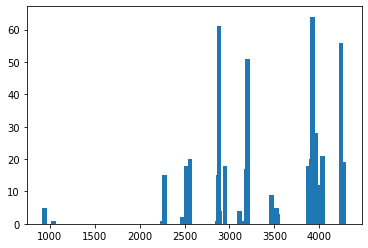

In [18]:
plot_distribution_diagramm(G, distribution_qaoa)

<div class='Implementation'> Based on these results we decided to pick the ten partitions with the highest counts, compute their cost functions and declare the partition with the highest outcome of these ten cost functions as the optimal solution of the qaoa. The function 'qaoa_solver' you will see in the next section exactly returns this cost and partition and some additional process data we wish to store.

# Benchmarking

<div class='Exp'>   First we will present on the example of the graph above, how the general benchmarking sceme works.

<div class='Implementation'> The 'qaoa-solver' takes as input a given Graph, the number of cuts that should be performed in the max-k-cut and the depth of the QAOA. Therefore this functions is in principle a wrapper of all steps described above.

<div class='Rmk'> It takes a very long time quite fast, recommended input is a Graph with maximally 8 nodes, a total number of k=4 cuts and an integer-valued QAOA depth between 1 and 5.

In [21]:
C_opt_qaoa, P_opt_qaoa, distribution_qaoa, param_history= qaoa_solver(G,k,p)

1st params [-0.26463419  6.73781342]
1st cost 0.3893763392857185
2nd iteration (EGG), params [-0.26463419 -0.1703586   6.73781342 11.62447867]
2nd iteration (EGG),  cost 0.39381272321428945
2nd iteration (Powell), params [-0.21101352 -0.24488753  7.78548188 11.00644469]
2nd iteration (Powell), cost 0.3887412946428617
3th iteration (EGG), params [-0.21101352 -0.24488753 -0.03503849  7.78548188 11.00644469  6.08899034]
3th iteration (EGG),  cost 0.39555825892857543
3th iteration (Powell), params [-0.32301459 -0.2646516   0.05537544  6.14562871 14.08889814  0.4517279 ]
3th iteration (Powell), cost 0.39608928571428986
C_opt_qaoa= 4276   P_opt_qaoa= {'P0': [0, 2], 'P1': [1], 'P2': [3], 'P3': [4]}


<div class='Implementation'> To compare the results obtained with the quantum-solver, we developed a 'Monte-Carlo-solver' as well. The Monte-Carlo solver takes as input a given Graph and the number of cuts that should be performed in the max-k-cut. It starts with a random partition of the nodes into k subsets, then it tries to take one of the nodes of one subset and put it into another subset. If the cost of this new configuration is higher than the cost of the old partition, then the old partition is overritten by the new partition. If the cost of the new partition is lower than the cost of the old partition the new partiton is only kept with a certain probability depending on the difference of the costs. The procudure of taking again a node and regroup it is repreated until the kept partition did not change for about 50 times. The kept partition and corresponding cost are returned

In [22]:
C_opt_mc, P_opt_mc =Monte_Carlo_solver(G,k)

C_opt_ms= 4276   P_opt_ms= {'P0': [3], 'P1': [1], 'P2': [4], 'P3': [2, 0]}


<div class='Implementation'> To see how well classical and quantum algorithm reallyperform, we need to compare their results with the real optimal value. The 'brut_force' functions goes via regression through all possible partitions and finds this way the optimal cost and the corresponding optimal participation.

<div class='Rmk'> For bigger graphs and/ or k this computations takes very long. To see how far the algorithm is, parameter 'print_progress' can be set to True to see a progress in percent. We do not recommended to use the function for more than 12 nodes of the graph (and k<9).

In [23]:
C_opt, P_opt=brut_force(G,k)

C_opt= 4276   P_opt= {'P0': [0, 2], 'P1': [4], 'P2': [3], 'P3': [1]}


<div class='Rmk'> For a small Graph with only 5 nodes, the results are usually very close or even fit the optimal value.

In [24]:
print('C_opt=', C_opt, '      P_opt=', P_opt, '\n')
print('C_opt_mc=', C_opt_mc, '    P_opt_mc=', P_opt_mc, '\n')
print('C_opt_qaoa=', C_opt_qaoa, '  P_opt_qaoa=', P_opt_qaoa, '\n')

C_opt= 4276       P_opt= {'P0': [0, 2], 'P1': [4], 'P2': [3], 'P3': [1]} 

C_opt_mc= 4276     P_opt_mc= {'P0': [3], 'P1': [1], 'P2': [4], 'P3': [2, 0]} 

C_opt_qaoa= 4276   P_opt_qaoa= {'P0': [0, 2], 'P1': [1], 'P2': [3], 'P3': [4]} 



## General Benchmark QAOA for N=5 and N=6    

<div class='Exp'> The sceme described above is now performed for N=5 and N=6 for different circuit depth between p=1 and p=5 and 5 repititions per parameter set.

<div class='Rmk'> The two following benchmarks take very long (about 3 hrs each)

In [26]:
qaoa_benchmark_dict_N5=general_benchmark_for_N(5, p_array=[1,2,3,4,5], repititions=5, k_array=[4])

In [30]:
qaoa_benchmark_dict_N6=general_benchmark_for_N(6, p_array=[1,2,3,4,5], repititions=5, k_array=[4])

<div class='Exp'> We plot the circuit depth on the x-axis and the approximation ratio on the y-axis. The approximation ratio is the obtained approximation value devided by the real optimal value. Two of the lines correspond to qaoa runs with N=5 and N=6, the vertical line shows the approximation ratio of the Monte-Carlo-Simulation with N=6.

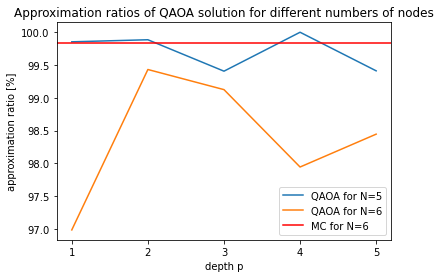

In [31]:
p_values_5, approximation_ratio_qaoa_5, approximation_ratio_mc_5= qaoa_benchmark_plot_data_N(qaoa_benchmark_dict_N5)
p_values_6, approximation_ratio_qaoa_6, approximation_ratio_mc_6= qaoa_benchmark_plot_data_N(qaoa_benchmark_dict_N6)
plt.figure()
plt.title('Approximation ratios of QAOA solution for different numbers of nodes')
plt.xlabel('depth p')
plt.ylabel('approximation ratio [%]')
plt.plot(p_values_5, approximation_ratio_qaoa_5, label='QAOA for N=5')
plt.plot(p_values_6, approximation_ratio_qaoa_6, label='QAOA for N=6')
plt.axhline(y=0.2*np.sum(approximation_ratio_mc_6), color='r', linestyle='-', label='MC for N=6')
plt.legend();

<div class='Exp'> As expected the result for the higher number of nodes (N=6) has the smaller approximation ratio. For the N=6 approximation one can also see an increase in the approximation ratio with growing QAOA depth. The high jumps of both N-values are due to only a few repetitions. By increasing the depth of the circuit further, one should notice an increase in the approximation ratio as well.

## General Benchmark QAOA vs Monte-Carlo

<div class='Exp'> In this benchmark we compare the QAOA-solver at depth P=3 with the Monte-Carlo solver for different numbers of nodes. We use 2 repititions for each parameter set to be able to receive solutions for higher N-values as well.

In [2]:
p_array=[3]
k_array=[4]
repititions=2
qaoa_benchmark_dict={}
for N in range(5,11,2):
    for k in k_array: 
        for p in p_array:
            for rep in range(repititions):
                n_imp = np.random.randint(N+1) 
                n_unimp = N-n_imp
            
                filename = "p_"+str(p)+"_N_"+str(N)+"_repetiton_"+str(rep)
                graph_name = "graph_"+filename
                data_name = "data_"+filename
            
                G = generate_data(n_unimp, n_imp, True, graph_name)
                C_opt_qaoa, P_opt_qaoa, distribution_qaoa, param_history = qaoa_solver(G,k,p)  
                C_opt_mc, P_opt_mc =Monte_Carlo_solver(G,k)
                C_opt, P_opt=brut_force(G,k)
            
                key=str(p)+str(N)
                if rep==0:
                    qaoa_benchmark_dict[key]=[[C_opt_qaoa, P_opt_qaoa, C_opt_mc, P_opt_mc, C_opt, P_opt]]
                else:
                    qaoa_benchmark_dict[key].append([C_opt_qaoa, P_opt_qaoa, C_opt_mc, P_opt_mc, C_opt, P_opt])
                         
            
                with open("created_data/"+data_name+".json", "wb") as f:
                    all_data = {}
                    all_data["n_imp"] = n_imp
                    all_data["n_unimp"] = n_unimp
                    all_data["C_opt_qaoa"] = C_opt_qaoa
                    all_data["P_opt_qaoa"] = P_opt_qaoa
                    all_data["C_opt_mc"] = C_opt_mc
                    all_data["P_opt_mc"] = P_opt_mc
                    all_data["C_opt"] = C_opt
                    all_data["P_opt"] = P_opt
                    all_data["distribution_qaoa"] = distribution_qaoa
                    #all_data["param_history"] = param_history

                    f.write(json.dumps(all_data, default=convert).encode("utf-8"))
    
    globals()['general_benchmark_%i' % N]=qaoa_benchmark_dict
    globals()['p_values_%i' % N], globals()['approximation_ratio_qaoa_%i' % N], globals()['approximation_ratio_mc_%i' % N]= qaoa_benchmark_plot_data_N(globals()['general_benchmark_%i' % N], repetition=2)


1st params [-1.72969338  9.77844169]
1st cost 0.572809734513276
2nd iteration (EGG), params [-1.72969338  1.45951356  9.77844169  8.94637277]
2nd iteration (EGG),  cost 0.5788674074819016
2nd iteration (Powell), params [-1.85497749  1.42341208  6.01181706 14.65702569]
2nd iteration (Powell), cost 0.5965205148833508
3th iteration (EGG), params [-1.85497749e+00  1.42341208e+00  8.85632413e-03  6.01181706e+00
  1.46570257e+01  2.50722714e+00]
3th iteration (EGG),  cost 0.6005088495575267
3th iteration (Powell), params [-1.84884984  1.38971561  0.01828664  5.25601387 14.08379191  5.03929075]
3th iteration (Powell), cost 0.5950497787610657
C_opt_qaoa= 4994   P_opt_qaoa= {'P0': [0, 2], 'P1': [1], 'P2': [3], 'P3': [4]}
C_opt_ms= 4994   P_opt_ms= {'P0': [4], 'P1': [1], 'P2': [0, 2], 'P3': [3]}
C_opt= 4994   P_opt= {'P0': [0, 2], 'P1': [4], 'P2': [3], 'P3': [1]}
1st params [2.89925179 8.49741145]
1st cost 0.6179282994923777
2nd iteration (EGG), params [ 2.89925179 -0.17772865  8.49741145 12.180

In [4]:
N_array=[5,7,9]
approximation_ratio_qaoa_array=[]
approximation_ratio_mc_array=[]
for n in N_array:
    approximation_ratio_qaoa_array.append(globals()['approximation_ratio_qaoa_%i' % n][0])
    approximation_ratio_mc_array.append(globals()['approximation_ratio_mc_%i' % n][0])

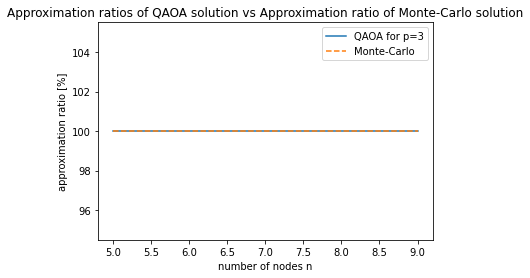

In [8]:
plt.figure()
plt.title('Approximation ratios of QAOA solution vs Approximation ratio of Monte-Carlo solution')
plt.xlabel('number of nodes n')
plt.ylabel('approximation ratio [%]')
plt.plot(N_array, approximation_ratio_qaoa_array, label='QAOA for p=3')
plt.plot(N_array, approximation_ratio_mc_array, label='Monte-Carlo', linestyle='dashed')
plt.legend();

<div class='Exp'> We did not expected such a good 100% agreement, with more repetitions and higher numbers of node one would hopefully see at some point differences between the Monte-carlo solution and the QAOA solution.